In [82]:
import torch
import torchvision
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import os
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import sys
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import copy
import random
import matplotlib.pyplot as plt

In [83]:
#1.加载数据
train_transform = transforms.Compose([
        transforms.Resize((500, 500)),  #这个要放在ToTensor前面
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.437, 0.435, 0.434],
                             std=[0.303, 0.300, 0.301])
    ])
valid_transform = transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor()
])

trainset = datasets.ImageFolder(root='data/Train',transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4, shuffle=True,num_workers=0)

validset = datasets.ImageFolder(root='data/Test',transform=valid_transform)
validloader = torch.utils.data.DataLoader(validset,batch_size=1, shuffle=True,num_workers=0)

classes = ['Audi Sedan', 'Audi SUV', 'BMW Sedan', 'BMW SUV', 'Brnz Sedan', 'Benz SUV']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


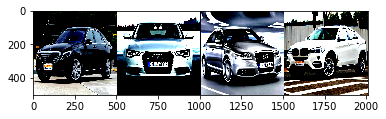

 Brnz Sedan    Audi Sedan    Audi Sedan       BMW SUV


In [84]:
#显示一些图片
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()   #images是一个batch中的图，labels是这个batch中图对应的class

imshow(torchvision.utils.make_grid(images))
print('   '.join('%11s'%classes[labels[j]] for j in range(4)))   #要加' '.join()不然只是出来一个iterable对象

In [85]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()  #失活率p默认0.5
#         self.fc1 = nn.Linear(20 * 122 * 122, 120)
#         self.fc2 = nn.Linear(120, 6)
        
#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 20 * 122 * 122)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training = self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim = 1)

In [86]:
#加载resnet网络模型，使用预训练好的参数，并将输出类别改为6
Net = resnet18(pretrained = True)
fc_features = Net.fc.in_features
Net.fc = nn.Linear(fc_features, 6)

In [87]:
device = torch.device('cuda:0')
net = Net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
# lr_step = optim.lr_scheduler.StepLR(optimizer, 5, gamma = 0.1, last_epoch=-1)

In [88]:
len(trainloader.dataset)

60

In [89]:
dataloders = {'train':trainloader, 'valid':validloader}

In [90]:
def train(model, epoches, dataloders, device, criterion, optimizer):
    valid_Acc = []
    train_Acc = []
    Loss = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(epoches):
        print('Epoch{}/{}'.format(epoch + 1, epoches))
        print('*'*20)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss, running_corrects = 0.0, 0.0

            for i, data in enumerate(dataloders[phase], 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):    #在训练的时候，tensor的requires_grad==true
                    outputs = net(inputs.float())
                    loss = criterion(outputs, labels)    #也就是说，在phase == valid的时候，loss是不能计算backward的
                    _, preds = torch.max(outputs, 1)  #得到每一batch的分类结果(train的时候一个batch是4个样本， valid的时候一个batch是1个样本)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0) #loss.item是一个batch的平均损失，*input.size(0)表示一个batch的总损失
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloders[phase].dataset)  #len(trainloader[phase])是batch数, len(trainloder[phase].dataset)是样本数
            epoch_acc = running_corrects.double() / len(dataloders[phase].dataset)
            
            if phase == 'train':
                train_Acc.append(epoch_acc)
                print('epoch:{}/{}, train_Loss:{}, train_Acc:{}'.format(epoch + 1, epoches, epoch_loss, epoch_acc))
            else:
                valid_Acc.append(epoch_acc)
                print('epoch:{}/{}, valid_Loss:{}, valid_Acc:{}'.format(epoch + 1, epoches, epoch_loss, epoch_acc))

            
            if phase == 'valid' and epoch_acc > best_acc:            #只记下在验证集上最好的结果
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
        
    model.load_state_dict(best_model_wts)
    return model, train_Acc, valid_Acc

In [91]:
model, train_Acc, valid_Acc = train(model = net, epoches = 10, dataloders = dataloders, device = device, criterion = criterion, optimizer = optimizer)

Epoch1/10
********************
epoch:1/10, train_Loss:1.9333998600641886, train_Acc:0.23333333333333334
epoch:1/10, valid_Loss:1.850902646780014, valid_Acc:0.16666666666666666
Epoch2/10
********************
epoch:2/10, train_Loss:1.6807679017384847, train_Acc:0.2
epoch:2/10, valid_Loss:1.6196668644746144, valid_Acc:0.5833333333333333
Epoch3/10
********************
epoch:3/10, train_Loss:1.306552811463674, train_Acc:0.6333333333333333
epoch:3/10, valid_Loss:1.4447604914506276, valid_Acc:0.5
Epoch4/10
********************
epoch:4/10, train_Loss:1.1705102324485779, train_Acc:0.6333333333333333
epoch:4/10, valid_Loss:1.5647073288758595, valid_Acc:0.41666666666666663
Epoch5/10
********************
epoch:5/10, train_Loss:0.8854887366294861, train_Acc:0.7166666666666667
epoch:5/10, valid_Loss:1.4950758516788483, valid_Acc:0.5
Epoch6/10
********************
epoch:6/10, train_Loss:0.5930940210819244, train_Acc:0.8166666666666667
epoch:6/10, valid_Loss:1.9044257601102192, valid_Acc:0.25
Epoch7/1

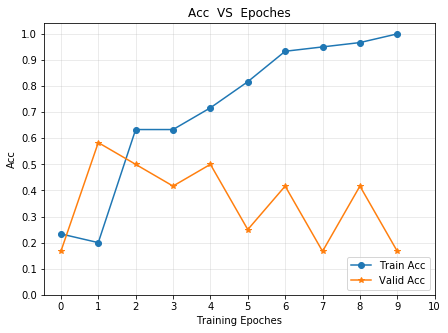

In [92]:
plt.figure(figsize = (7, 5))
plt.title('Acc  VS  Epoches')
plt.xlabel('Training Epoches')
plt.ylabel('Acc')
plt.plot(train_Acc, label = 'Train Acc', marker = 'o')
plt.plot(valid_Acc, label = 'Valid Acc', marker = '*')
x_ = np.linspace(0, 10, 11)
y_ = np.linspace(0, 1, 11)
plt.xticks(x_)
plt.yticks(y_)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()